"""
Basic distance-based and cointegration-based pairs trading,
following the classic literature summarized in Krauss (2015).

Distance: Gatev, Goetzmann, Rouwenhorst (2006)
Cointegration: Vidyamurthy (2004) / Engle–Granger approach
"""

In [ ]:
# Reload modules if source files have changed
# Run this cell after modifying any .py files to see changes without restarting kernel
import importlib
import sys

# Store reference to globals
_globals = globals()

def reload_modules():
    """Reload all custom modules and update namespace."""
    modules_to_reload = {
        'plot': ['plot'],
        'ou': ['ou'], 
        'cointegration': ['cointegration'],
        'distance': ['distance'],
        'utilities': ['utilities']
    }
    
    for module_name, import_names in modules_to_reload.items():
        if module_name in sys.modules:
            importlib.reload(sys.modules[module_name])
            print(f"Reloaded: {module_name}")
    
    # Re-import modules properly
    import plot
    import ou
    import cointegration
    import distance
    import utilities
    
    # Update globals with all exported names from each module
    for module in [plot, ou, cointegration, distance, utilities]:
        _globals.update({k: v for k, v in module.__dict__.items() if not k.startswith('_')})
    
    print("All modules reloaded and re-imported!")



In [24]:
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Our Modules
from plot import *
from ou import *
from cointegration import *
from distance import *
from utilities import *

reload_modules()

Reloaded: plot
Reloaded: ou
Reloaded: cointegration
Reloaded: distance
Reloaded: utilities
All modules reloaded and re-imported!


In [34]:
# 1) Utilities (XLU-style)
utilities_universe_2010 = [
    "NEE", "SO", "DUK", "AEP", "SRE", "D", "XEL", "EXC", "ETR", "PEG",
    "ED", "WEC", "PCG", "NRG", "ATO", "DTE", "AEE", "PPL", "CNP", "AWK",
    "ES", "FE", "EIX", "CMS", "NI", "EVRG", "LNT", "PNW", "AES",
]

# 2) U.S. REITs / Real Estate (IYR-style)
reits_universe_2010 = [
    "WELL", "PLD", "SPG", "AMT", "O", "EQIX", "DLR", "CBRE", "PSA", "CCI",
    "VTR", "CSGP", "EXR", "AVB", "IRM", "EQR", "SBAC", "ESS", "MAA", "JLL",
    "WY", "SUI", "WPC", "NLY", "KIM", "OHI", "ELS", "LAMR", "REG",
]


# 3) Consumer Staples (XLP-style)
staples_universe_2010 = [
    "WMT", "COST", "PG", "KO", "PM", "PEP", "CL", "MO", "TGT", "KR",
    "SYY", "KMB", "ADM", "DG", "HSY", "EL", "GIS", "DLTR", "K", "CHD",
    "STZ", "MKC", "TSN", "BG", "CLX", "SJM", "CAG", "TAP", "HRL", "CPB",
]

In [38]:
print(len(staples_universe_2010))

30


In [40]:
# Example universe: combined sector-specific stocks
# universe = reits_universe_2010 + utilities_universe_2010 + staples_universe_2010
universe = reits_universe_2010
# universe = utilities_universe_2010
# universe = staples_universe_2010

# Choose a data range within Yahoo Finance's daily history
start_date = "2010-01-01"
end_date = "2019-01-01"

print("Downloading data...")
prices = download_price_data(universe, start=start_date, end=end_date)
print(f"Got data from {prices.index[0].date()} to {prices.index[-1].date()} for {len(prices.columns)} tickers.")

Got data from 2010-01-04 to 2018-12-31 for 29 tickers.


Got data from 2010-01-04 to 2018-12-31 for 29 tickers.

=== Distance-based pairs trading ===
Trading days        : 1959
Number of trades    : 136
Total profit        : 0.0438
Final equity        : 1.0438
CAGR                : 0.55%
Sharpe (annual)     : 0.24
Max drawdown        : -5.56%
Average utilization   : 55.71%
Avg active pairs/day  : 5.57

=== Cointegration-based pairs trading ===
Trading days        : 1959
Number of trades    : 142
Total profit        : 0.2055
Final equity        : 1.2055
CAGR                : 2.43%
Sharpe (annual)     : 0.43
Max drawdown        : -14.95%
Average utilization   : 75.42%
Avg active pairs/day  : 7.54

=== OU time-series pairs trading ===
Trading days        : 1960
Number of trades    : 204
Total profit        : 0.0954
Final equity        : 1.0954
CAGR                : 1.18%
Sharpe (annual)     : 0.55
Max drawdown        : -2.68%


C:\Users\Segyul\AppData\Local\Temp\ipykernel_45112\3545832793.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


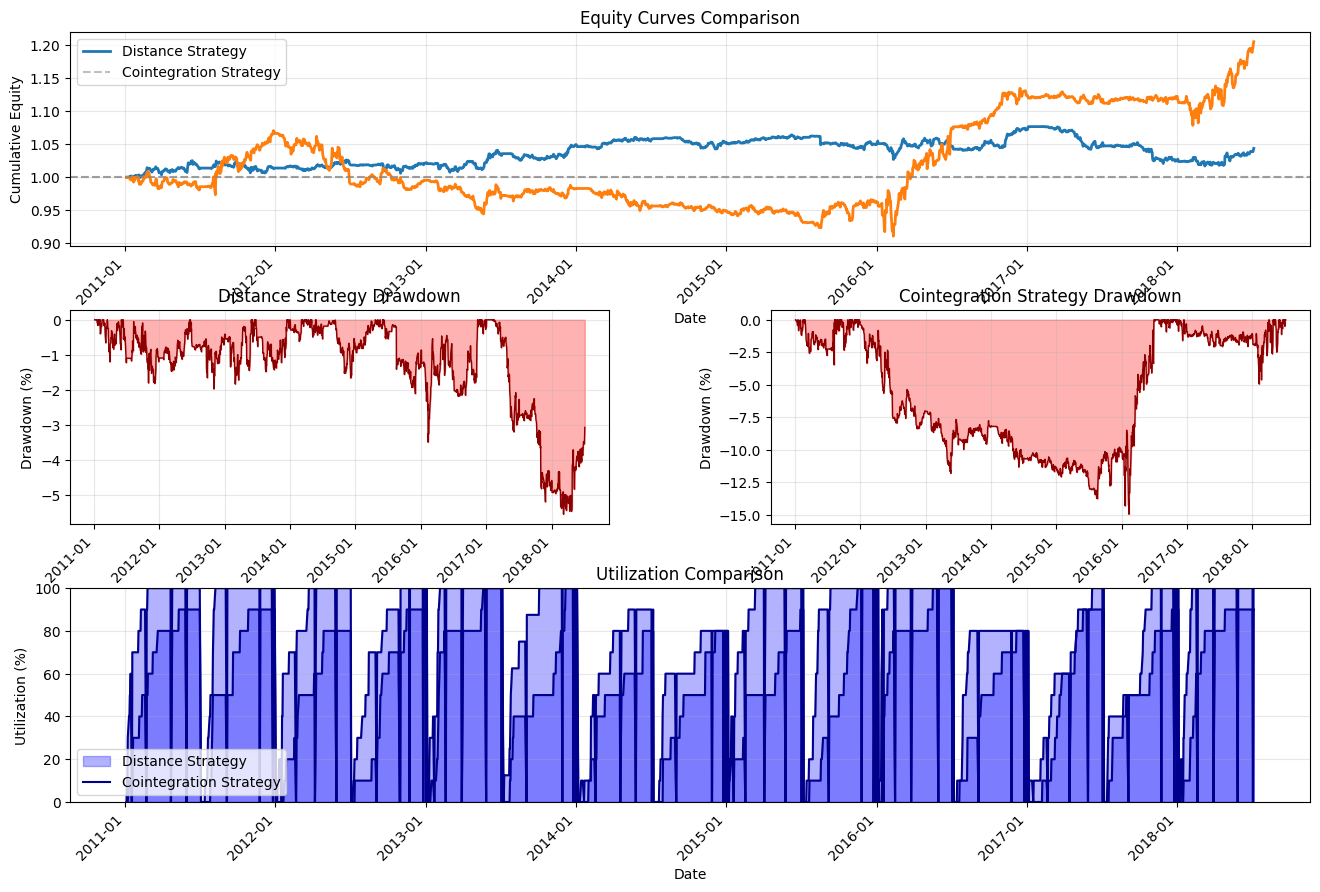

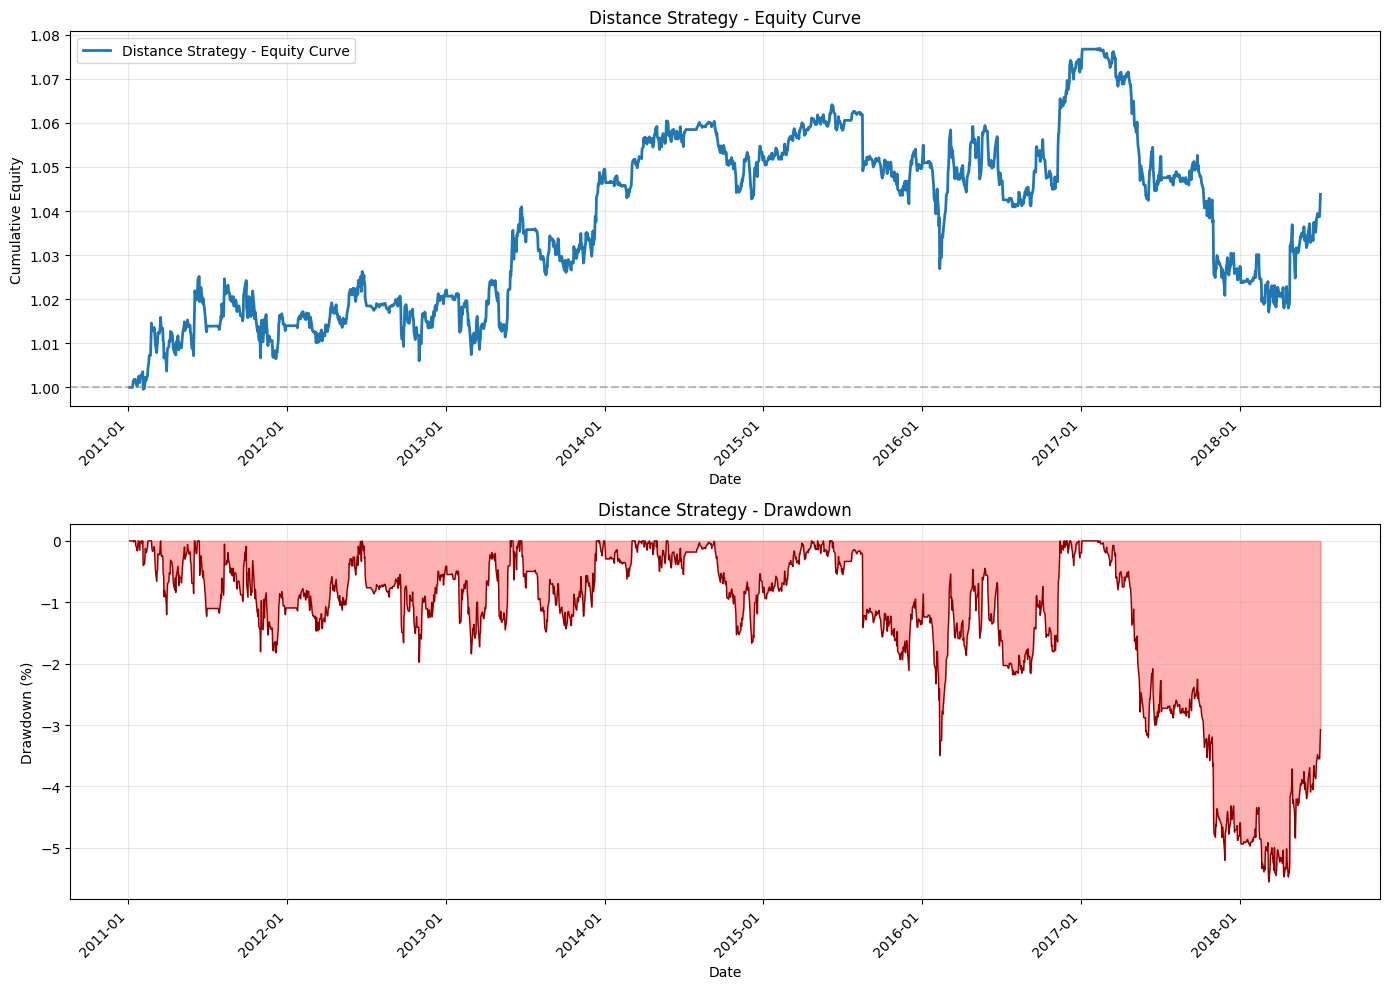

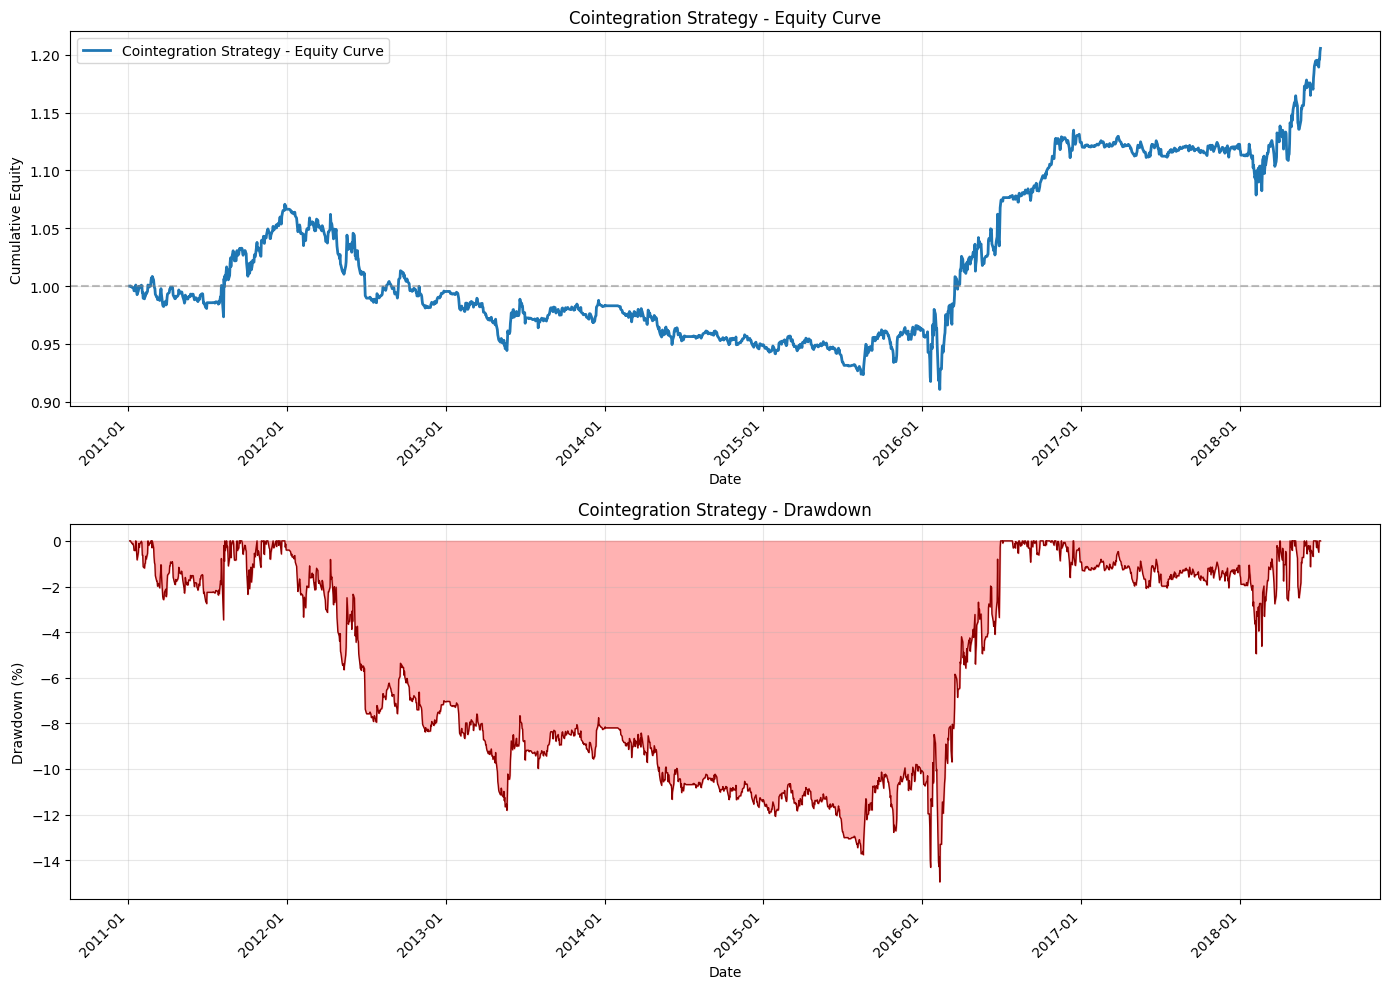

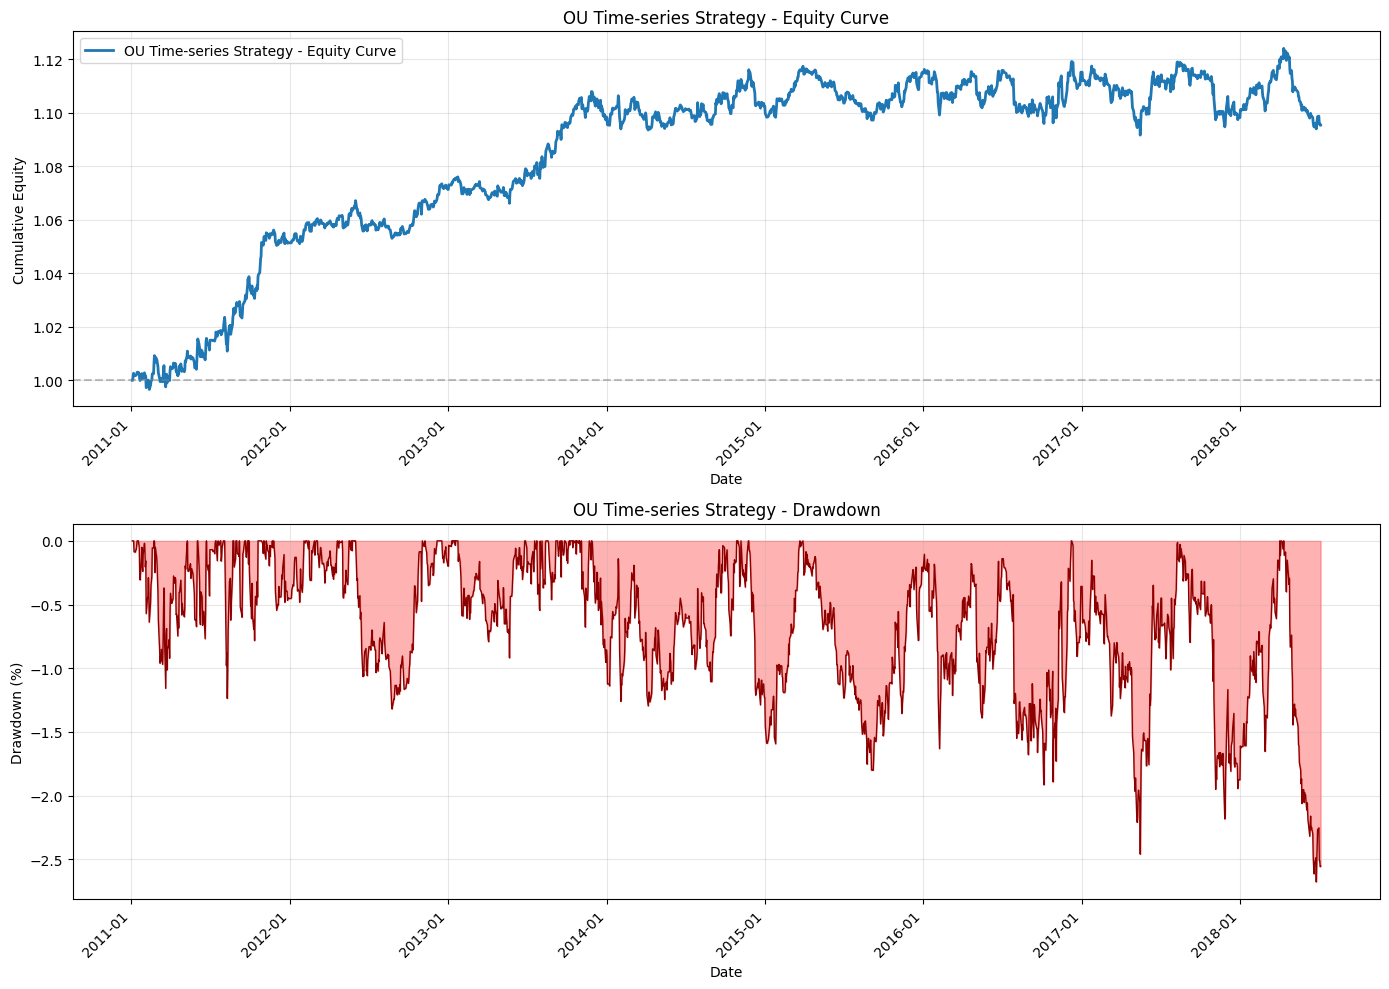

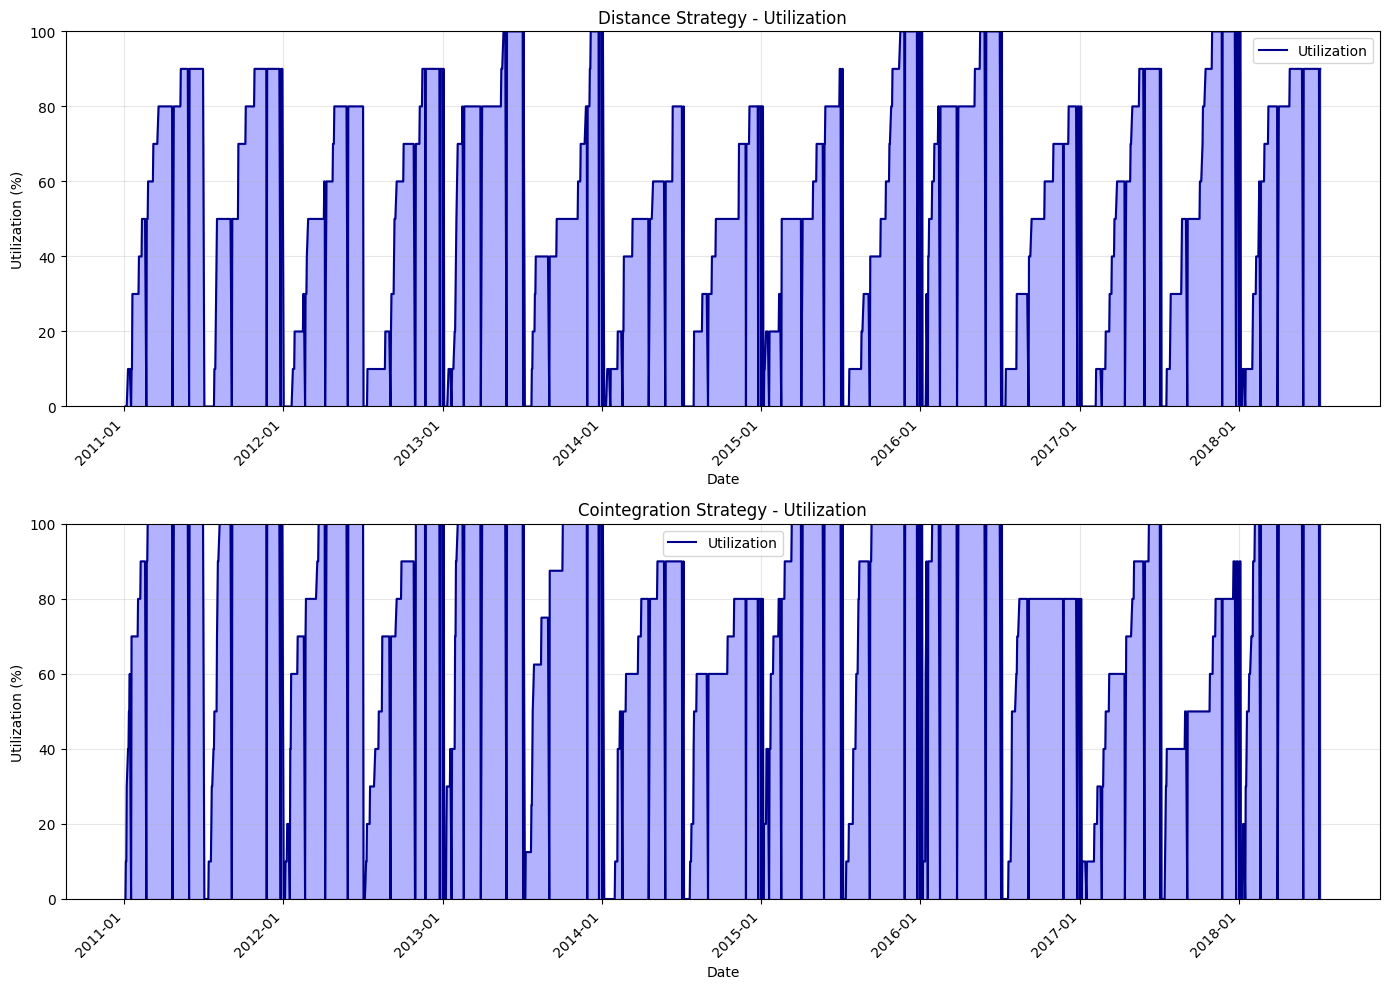

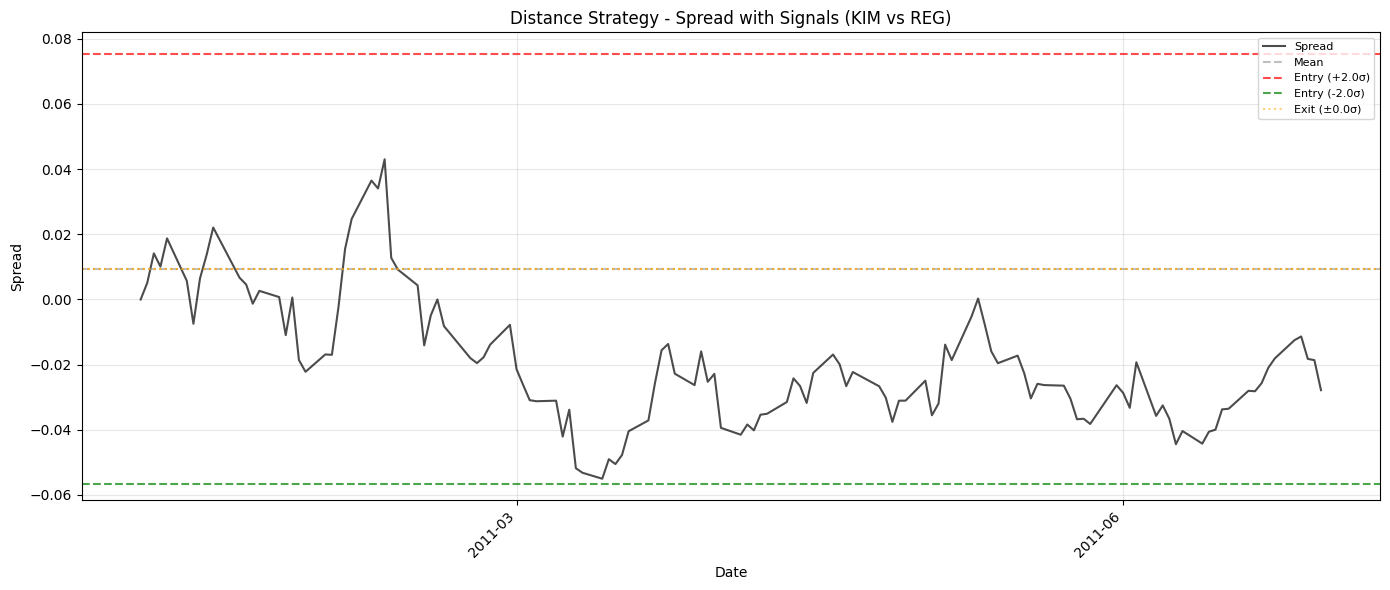

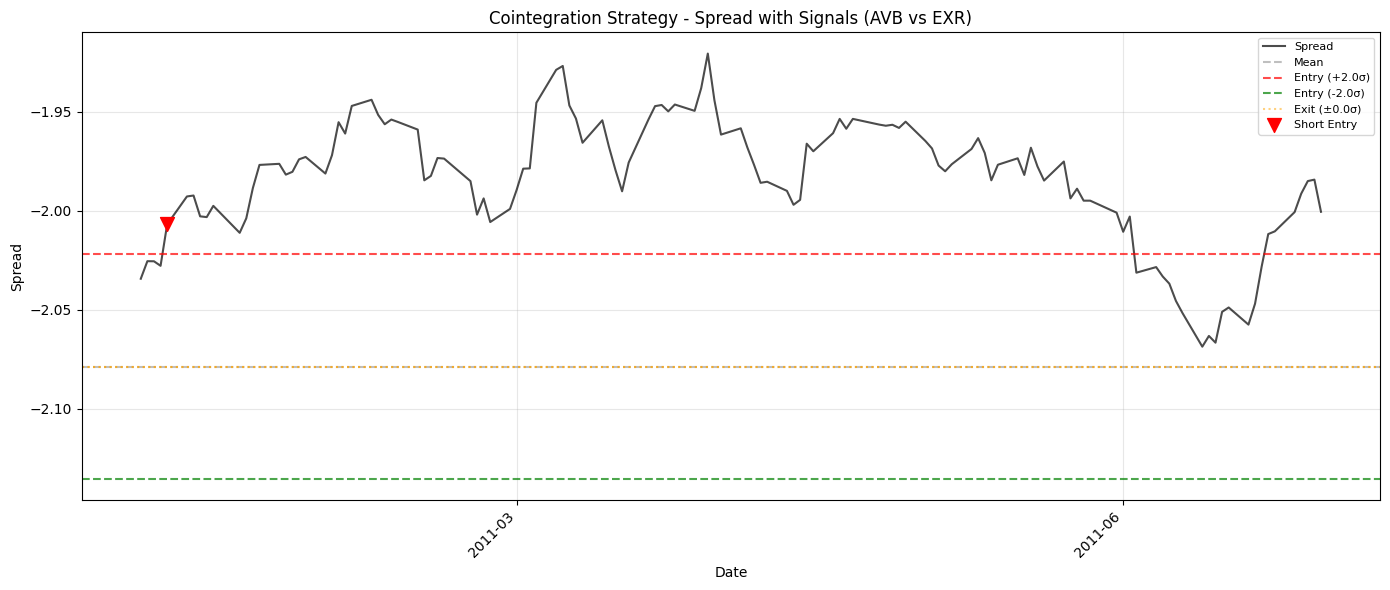

In [ ]:
# Strategy comparison plot (distance vs cointegration as before)
plot_strategy_comparison(dist_returns, coint_returns, dist_util, coint_util)
plt.show()

# Utilization plots (only for distance & cointegration; OU not tracked here)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_utilization(dist_util, title="Distance Strategy - Utilization", ax=axes[0])
plot_utilization(coint_util, title="Cointegration Strategy - Utilization", ax=axes[1])
plt.tight_layout()
plt.show()

# Spread visualization for first trading window
num_days = len(prices)
first_start = 0
if first_start < num_days - formation_days - trading_days:
    formation = prices.iloc[first_start : first_start + formation_days]
    trading = prices.iloc[first_start + formation_days : first_start + formation_days + trading_days]
    trading_window = trading.index

    # Distance strategy - plot first pair
    dist_pair_info = select_pairs_distance(formation, top_n_pairs=top_n_pairs)
    if dist_pair_info:
        fig, ax = plt.subplots(figsize=(14, 6))
        plot_spread_with_signals(
            prices.loc[trading_window[0]:trading_window[-1]],
            dist_pair_info[0],
            trading_window,
            strategy_type='distance',
            entry_z=2.0,
            exit_z=0.0,
            title="Distance Strategy - Spread with Signals",
            ax=ax,
        )
        plt.tight_layout()
        plt.show()

    # Cointegration strategy - plot first pair
    coint_pair_info = select_pairs_cointegration(
        formation,
        top_n_pairs=top_n_pairs,
        pvalue_threshold=0.05,
    )
    if coint_pair_info:
        fig, ax = plt.subplots(figsize=(14, 6))
        plot_spread_with_signals(
            prices.loc[trading_window[0]:trading_window[-1]],
            coint_pair_info[0],
            trading_window,
            strategy_type='cointegration',
            entry_z=2.0,
            exit_z=0.0,
            title="Cointegration Strategy - Spread with Signals",
            ax=ax,
        )
        plt.tight_layout()
        plt.show()




=== Distance-based pairs trading ===
Trading days        : 1959
Number of trades    : 136
Total profit        : 0.0438
Final equity        : 1.0438
CAGR                : 0.55%
Sharpe (annual)     : 0.24
Max drawdown        : -5.56%
Average utilization   : 55.71%
Avg active pairs/day  : 5.57

=== Cointegration-based pairs trading ===
Trading days        : 1959
Number of trades    : 142
Total profit        : 0.2055
Final equity        : 1.2055
CAGR                : 2.43%
Sharpe (annual)     : 0.43
Max drawdown        : -14.95%
Average utilization   : 75.42%
Avg active pairs/day  : 7.54

=== OU time-series pairs trading ===
Trading days        : 1960
Number of trades    : 204
Total profit        : 0.0954
Final equity        : 1.0954
CAGR                : 1.18%
Sharpe (annual)     : 0.55
Max drawdown        : -2.68%

=== OU time-series pairs trading ===
Trading days        : 1960
Number of trades    : 251
Total profit        : 0.0653
Final equity        : 1.0653
CAGR                : 0.82

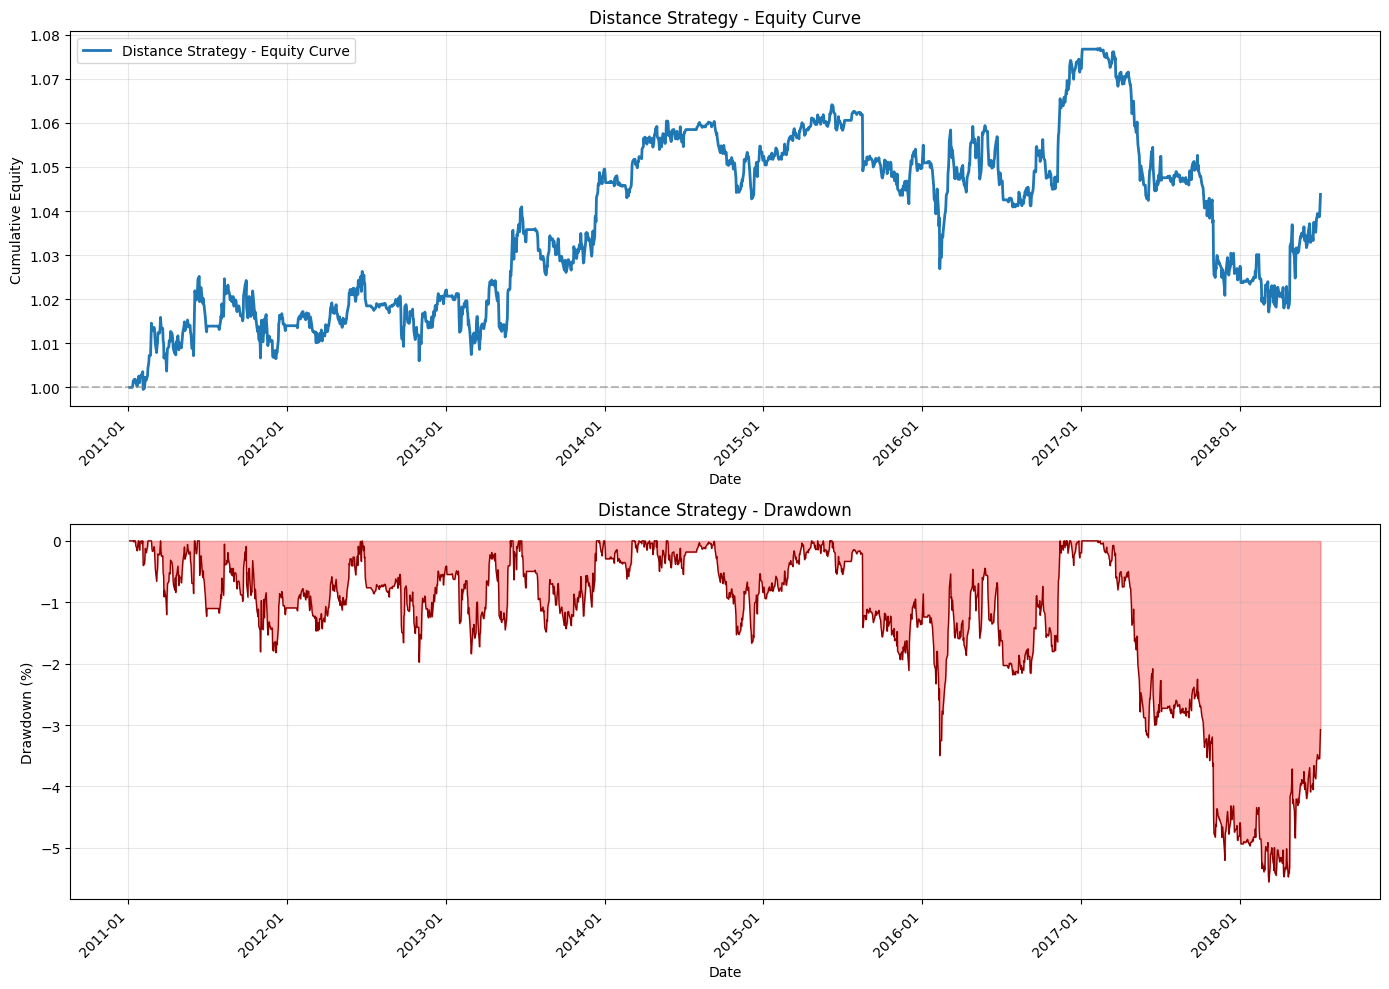

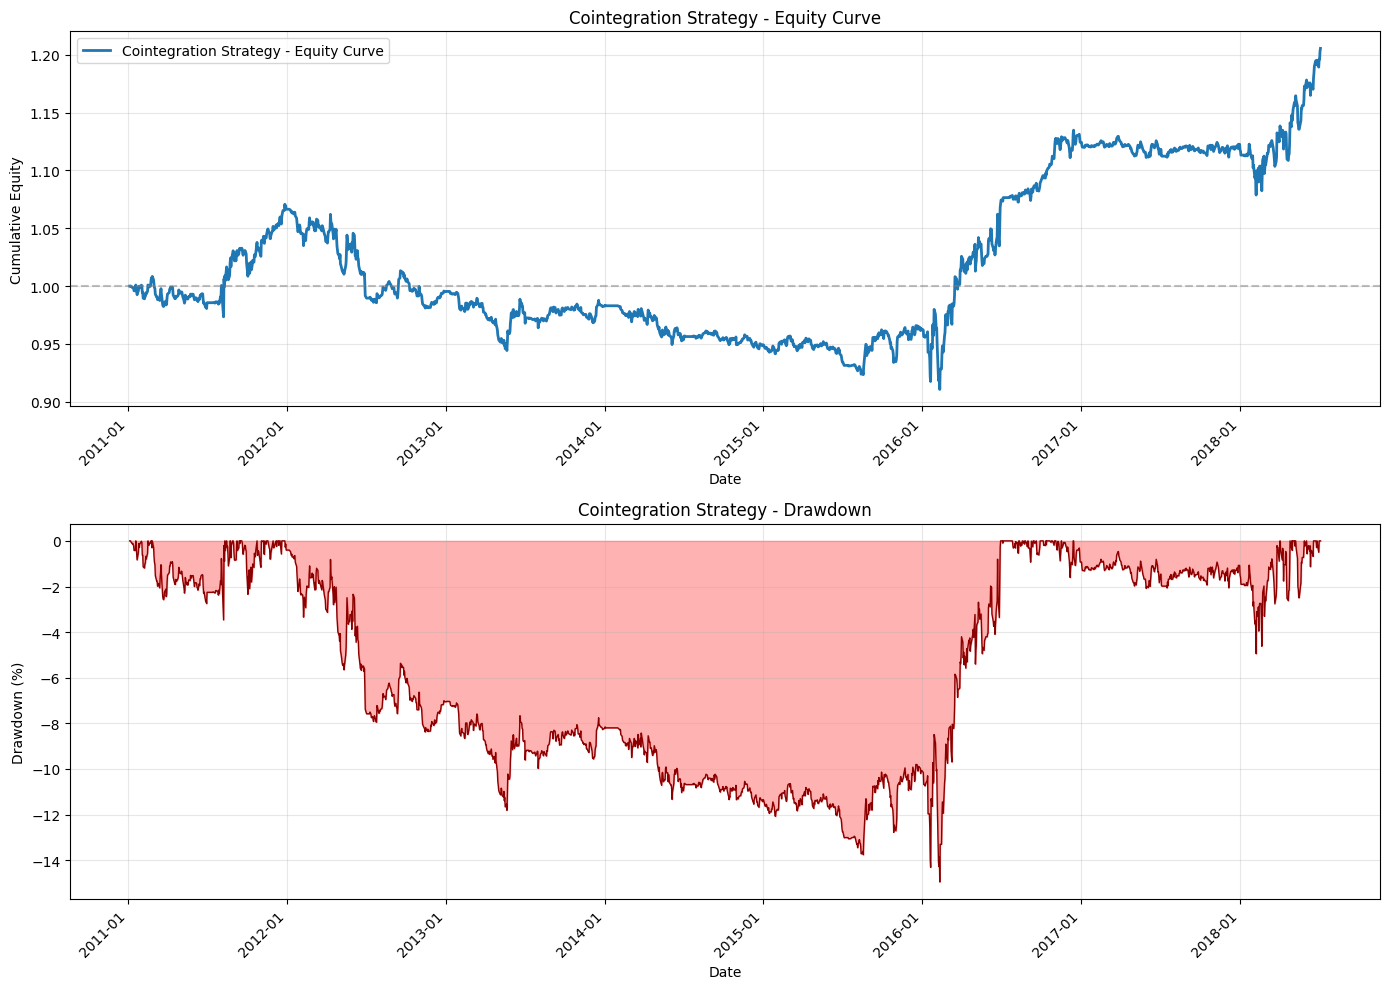

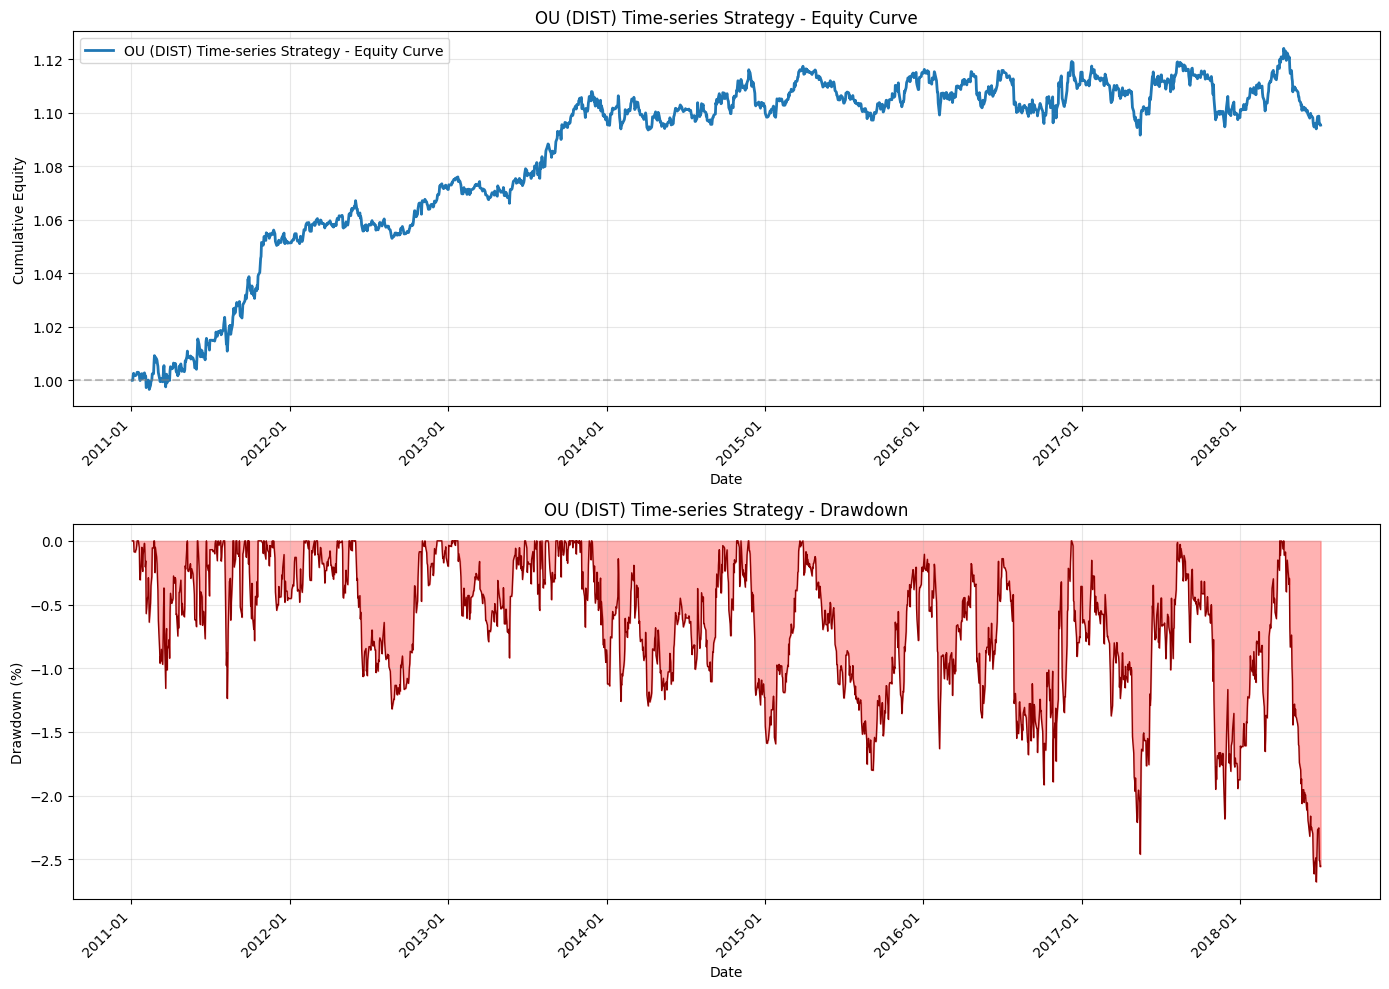

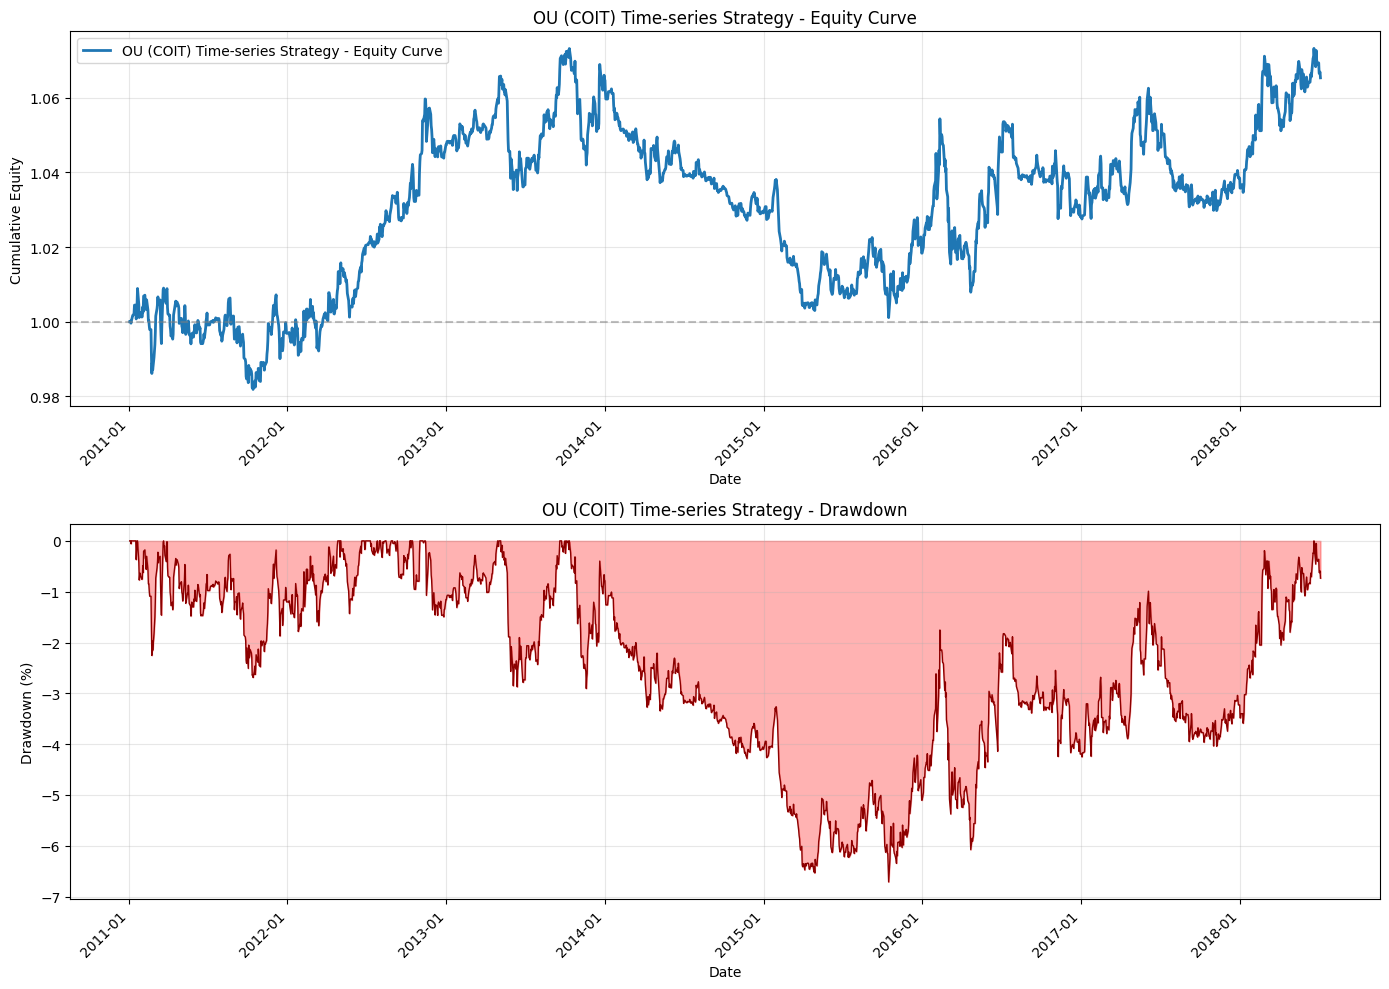

In [41]:
# Parameters roughly in line with Gatev et al. (12m formation, 6m trading)
formation_days = 252   # ~12 months
trading_days = 126     # ~6 months
top_n_pairs = 10       # fewer pairs to keep computation reasonable

# Distance-based strategy
dist_returns, dist_util, dist_trades = backtest_distance(
    prices,
    formation_days=formation_days,
    trading_days=trading_days,
    top_n_pairs=top_n_pairs,
)
dist_metrics = compute_performance_metrics(dist_returns)

avg_util = dist_util.mean()  # average fraction of pairs in use
avg_active_pairs = avg_util * top_n_pairs

print_metrics("Distance-based pairs trading", dist_metrics, dist_trades)
print(f"Average utilization   : {avg_util:.2%}")
print(f"Avg active pairs/day  : {avg_active_pairs:.2f}")

# Cointegration-based strategy
coint_returns, coint_util, coint_trades = backtest_cointegration(
    prices,
    formation_days=formation_days,
    trading_days=trading_days,
    top_n_pairs=top_n_pairs,
    pvalue_threshold=0.05,
)
coint_metrics = compute_performance_metrics(coint_returns)

avg_util_coint = coint_util.mean()
avg_active_pairs_coint = avg_util_coint * top_n_pairs

print_metrics("Cointegration-based pairs trading", coint_metrics, coint_trades)
print(f"Average utilization   : {avg_util_coint:.2%}")
print(f"Avg active pairs/day  : {avg_active_pairs_coint:.2f}")

# OU time-series strategy (on distance-selected pairs)
# Use the first formation window to define a fixed set of candidate pairs
first_formation = prices.iloc[0:formation_days]
ou_candidate_dist = select_pairs_distance(first_formation, top_n_pairs=top_n_pairs)
ou_candidate_coit = select_pairs_cointegration(first_formation, top_n_pairs=top_n_pairs)


ou_dist_returns, ou_dist_trades = backtest_ou_time_series(
    prices,
    pair_info=ou_candidate_dist,     # distance-style pairs: {"stock1", "stock2"}
    formation_days=formation_days,
    trading_days=trading_days,
    transaction_cost=0.0,
    top_n_pairs=top_n_pairs,
)
ou_dist_metrics = compute_performance_metrics(ou_dist_returns)

print_metrics("OU time-series pairs trading", ou_dist_metrics, ou_dist_trades)

ou_coit_returns, ou_coit_trades = backtest_ou_time_series(
    prices,
    pair_info=ou_candidate_coit,     # distance-style pairs: {"stock1", "stock2"}
    formation_days=formation_days,
    trading_days=trading_days,
    transaction_cost=0.0,
    top_n_pairs=top_n_pairs,
)
ou_coit_metrics = compute_performance_metrics(ou_coit_returns)

print_metrics("OU time-series pairs trading", ou_coit_metrics, ou_coit_trades)

# Plotting
# Distance equity & drawdown
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_equity_curve(dist_returns, title="Distance Strategy - Equity Curve", ax=axes[0])
plot_drawdown(dist_returns, title="Distance Strategy - Drawdown", ax=axes[1])
plt.tight_layout()
plt.show()

# Cointegration equity & drawdown
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_equity_curve(coint_returns, title="Cointegration Strategy - Equity Curve", ax=axes[0])
plot_drawdown(coint_returns, title="Cointegration Strategy - Drawdown", ax=axes[1])
plt.tight_layout()
plt.show()

# OU (base dist) equity & drawdown 
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_equity_curve(ou_dist_returns, title="OU (DIST) Time-series Strategy - Equity Curve", ax=axes[0])
plot_drawdown(ou_dist_returns, title="OU (DIST) Time-series Strategy - Drawdown", ax=axes[1])
plt.tight_layout()
plt.show()

# OU (base coit) equity & drawdown
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_equity_curve(ou_coit_returns, title="OU (COIT) Time-series Strategy - Equity Curve", ax=axes[0])
plot_drawdown(ou_coit_returns, title="OU (COIT) Time-series Strategy - Drawdown", ax=axes[1])
plt.tight_layout()
plt.show()


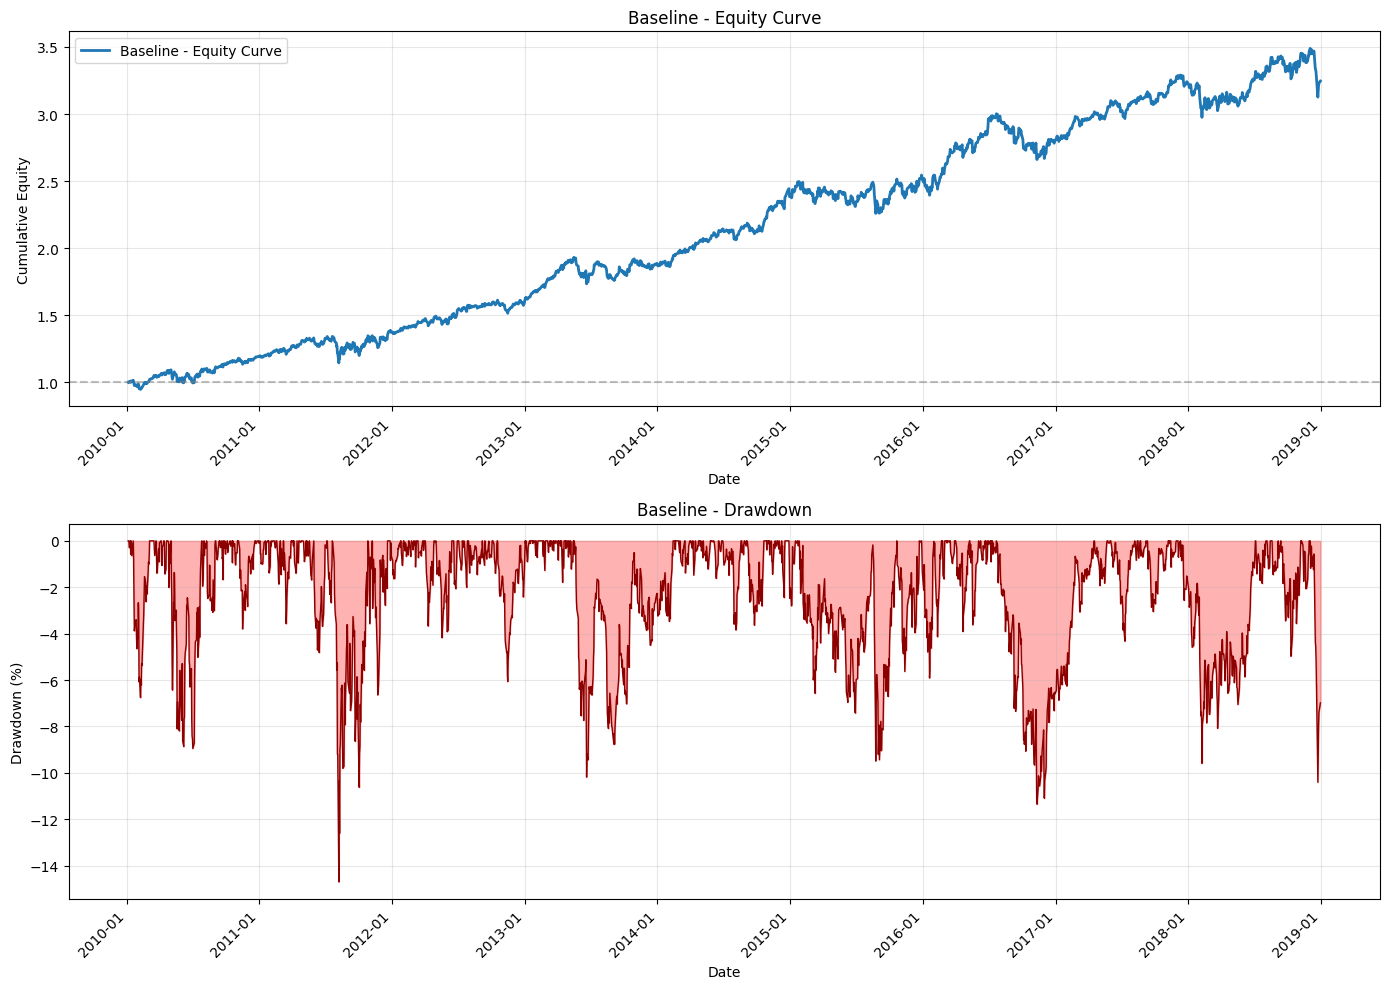

In [31]:
# Equal Weighted Portfolio
baseline_port = compute_equal_weighted_returns(prices)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_equity_curve(baseline_port, title="Baseline - Equity Curve", ax=axes[0])
plot_drawdown(baseline_port, title="Baseline - Drawdown", ax=axes[1])
plt.tight_layout()
plt.show()